<a href="https://colab.research.google.com/github/archit436/Birds_Classifier/blob/main/Models/Main_Models/Main_Model_Audio_Main_File.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

0. Setup

In [1]:
# Start by importing the relevant libraries.
# Copied from Archit's Lab 3 Submission and then some more.
import os
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

1. Data Preprocessing - HOG Features of Spectrograns

In [ ]:
# Mount the drive.
from google.colab import drive
drive.mount('/content/drive')
# Import the csv file with the data details
csv_path = "/content/drive/MyDrive/APS360_Team_15/Data_Processing/chosen_classes_data_stats.csv"
birds_df = pd.read_csv(csv_path)
birds_df.head()

Mounted at /content/drive


,Class ID,Images Count,XC Recordings Count,Species Name,XC Species Name
0,315,116,167,Gadwall (Breeding male),Gadwall
1,317,120,240,Mallard (Breeding male),Mallard
2,333,105,114,Common Goldeneye (Breeding male),Common Goldeneye
3,338,116,89,California Quail (Male),California Quail
4,352,120,285,Black-crowned Night-Heron (Adult),Black-crowned Night Heron


In [ ]:
# Now we move on to loading the category.pt files defined for each class.
# Define the directory of the audio data.
xc_data_dir = '/content/drive/MyDrive/APS360_Team_15/Data/Xeno_Canto'

# Define lists to store the tensors extracted from the .pt files.
all_features = []
all_labels = []

# Iterate through all the birds, skipping the ones without a .pt file.
for it_bird in range(birds_df.shape[0]):
  # Find the bird class ID and accordingly find the corresponding .pt file.
  bird_class_id = birds_df.loc[it_bird, 'Class ID']
  pt_file = glob.glob(os.path.join(xc_data_dir, str(bird_class_id), '*.pt'))
  # Check if .pt file exists for this bird.
  if(pt_file == []):
    continue
  # Iterate through all the pt files for this bird.
  for pt_file in pt_file:
    # Extract the data into a tensor.
    features_tensor = torch.load(pt_file)
    # Populate the lists with the features and labels tensors.
    # For labels, we create a 1D tensor with num_samples of class id values.
    num_samples = features_tensor['features'].shape[0]
    all_features.append(features_tensor['features'])
    all_labels.append(torch.full((num_samples,), bird_class_id, dtype=torch.long))

<ipython-input-11-ad1f6ea53532>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  features_tensor = torch.load(pt_file)


In [ ]:
# Print out number of classes for which data has been extracted.
class_ids = [tensor[0].item() for tensor in all_labels]
labels_set = sorted(set(class_ids))
num_classes = len(labels_set)
print(f"Number of classes for which data has been extracted: {num_classes}")

Number of classes for which data has been extracted: 101


In [ ]:
# Concatenate all the tensors into one tensor.
features_tensor = torch.cat(all_features, dim=0)
labels_tensor = torch.cat(all_labels, dim=0)

# Encode the labels to make them suitable for training the model.
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels_tensor)
# Create mapping dictionaries for the encoding.
id_to_index = dict(zip(labels_tensor, encoded_labels))
index_to_id = dict(zip(encoded_labels, labels_tensor))
# Pickle dump these mappings for use later.
with open('label_mappings.pkl', 'wb') as f:
    pickle.dump({'id_to_index': id_to_index, 'index_to_id': index_to_id}, f)

# Replace the labels tensor.
labels_tensor = torch.from_numpy(encoded_labels)

# Print out stats.
print(f"Shape of features tensor: {features_tensor.shape}")
print(f"Shape of labels tensor: {labels_tensor.shape}")

# Convert the tensors into numpy for sci-kit learn functions.
features_np = features_tensor.numpy()
labels_np = labels_tensor.numpy()

# First split: (training + validation) vs test - 80:20
# We use a stratified split for uniform distributions of the classes.
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
temp_idx, test_idx = next(sss1.split(features_np, labels_np))

# Get the temporary set.
temp_features_np = features_np[temp_idx]
temp_labels_np = labels_np[temp_idx]

# Second split: training vs validation - 80:20
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
train_idx, val_idx = next(sss2.split(temp_features_np, temp_labels_np))

Shape of features tensor: torch.Size([17687, 1764])
Shape of labels tensor: torch.Size([17687])


In [ ]:
# Use the split indices to extract the data.
test_features_np = features_np[test_idx]
test_labels_np = labels_np[test_idx]
train_features_np = temp_features_np[train_idx]
train_labels_np = temp_labels_np[train_idx]
val_features_np = temp_features_np[val_idx]
val_labels_np = temp_labels_np[val_idx]

print(f"Shape of training features tensor: {train_features_np.shape}")
print(f"Shape of training labels tensor: {train_labels_np.shape}")
print(f"Shape of validation features tensor: {val_features_np.shape}")
print(f"Shape of validation labels tensor: {val_labels_np.shape}")
print(f"Shape of test features tensor: {test_features_np.shape}")
print(f"Shape of test labels tensor: {test_labels_np.shape}")

Shape of training features tensor: (11319, 1764)
Shape of training labels tensor: (11319,)
Shape of validation features tensor: (2830, 1764)
Shape of validation labels tensor: (2830,)
Shape of test features tensor: (3538, 1764)
Shape of test labels tensor: (3538,)


In [ ]:
# Convert the numpy arrays back to tensors.
train_features_tensor = torch.from_numpy(train_features_np)
train_labels_tensor = torch.from_numpy(train_labels_np)
val_features_tensor = torch.from_numpy(val_features_np)
val_labels_tensor = torch.from_numpy(val_labels_np)
test_features_tensor = torch.from_numpy(test_features_np)
test_labels_tensor = torch.from_numpy(test_labels_np)

print(f"Shape of training features tensor: {train_features_tensor.shape}")
print(f"Shape of training labels tensor: {train_labels_tensor.shape}")
print(f"Shape of validation features tensor: {val_features_tensor.shape}")
print(f"Shape of validation labels tensor: {val_labels_tensor.shape}")
print(f"Shape of test features tensor: {test_features_tensor.shape}")
print(f"Shape of test labels tensor: {test_labels_tensor.shape}")

Shape of training features tensor: torch.Size([11319, 1764])
Shape of training labels tensor: torch.Size([11319])
Shape of validation features tensor: torch.Size([2830, 1764])
Shape of validation labels tensor: torch.Size([2830])
Shape of test features tensor: torch.Size([3538, 1764])
Shape of test labels tensor: torch.Size([3538])


In [ ]:
# Create the datasets using the data tensors.
# This combines the labels and feature tensors.
# These can be used to create the dataloaders later.
train_dataset = TensorDataset(train_features_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_features_tensor, val_labels_tensor)
test_dataset = TensorDataset(test_features_tensor, test_labels_tensor)

2. CNN Model Implementation - HOG Features of Spectograms

In [ ]:
# Define the CNN Model.
class HOGFeatureCNN(nn.Module):
    def __init__(self, num_classes=num_classes):
        super(HOGFeatureCNN, self).__init__()

        self.name = "HOGFeatureCNN"

        # Reshape HOG features to 2D.
        # The CNN expects input as [batch_size, channels, height, width]
        self.reshape_size = (42, 42)  # 42*42 = 1764

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1) # 1x42x42 -> 32x42x42
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # 32x21x21 -> 64x21x21
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # 64x10x10 -> 128x10x10
        self.bn3 = nn.BatchNorm2d(128)

        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # Calculate size after convolutions and pooling
        # After 3 pooling operations of 2x2, dimensions are reduced by factor of 8
        fc_input_size = 128 * (self.reshape_size[0] // 8) * (self.reshape_size[1] // 8)

        # Fully connected layers
        self.fc1 = nn.Linear(fc_input_size, 512)
        self.dropout = nn.Dropout(0.5) # for regularisation.
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # Reshape HOG features to 2D + add channel dimension
        x = x.view(-1, 1, self.reshape_size[0], self.reshape_size[1])

        # Convolutional blocks
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        # Flatten for fully connected layers
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x


In [ ]:
use_cuda = True

In [ ]:
# Helper function to create a name for each model on the basis of its hyperparameters.
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [ ]:
# Function to train the model. Largely based on Archit's Lab 3 Submission.
def train_net(model, batch_size, train_loader, val_loader, learning_rate=0.001, num_epochs=20):
    # Fixed PyTorch random seed for reproducible results
    torch.manual_seed(1000)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    # Optional: Add scheduler later - it controls the learning rate.
    print("Loss Function and Optimizer set up.")

    # Arrays to store accuracy metrics
    train_acc = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)

    # Training loop
    start_time = time.time()
    print("Training Started.")

    # Iterate for number of epochs.
    for epoch in range(num_epochs):
        # Training phase
        model.train()

        # Process training batches
        for _, data in enumerate(train_loader, 0):
            recordings, labels = data

            # Move data to GPU if available
            if use_cuda and torch.cuda.is_available():
                recordings = recordings.cuda()
                labels = labels.cuda()

            # Forward and backward passes
            optimizer.zero_grad()
            outputs = model(recordings)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        print("Finished with adjusting parameters")

        # Evaluation phase
        model.eval()
        correct_t, total_t = 0, 0
        correct_v, total_v = 0, 0

        # Calculate training accuracy
        with torch.no_grad():
            for recordings, labels in train_loader:
                if use_cuda and torch.cuda.is_available():
                    recordings = recordings.cuda()
                    labels = labels.cuda()

                output = model(recordings)
                pred = output.max(1, keepdim=True)[1]
                correct_t += pred.eq(labels.view_as(pred)).sum().item()
                total_t += recordings.shape[0]

        train_acc[epoch] = correct_t / total_t

        # Calculate validation accuracy
        with torch.no_grad():
            for recordings, labels in val_loader:
                if use_cuda and torch.cuda.is_available():
                    recordings = recordings.cuda()
                    labels = labels.cuda()

                output = model(recordings)
                pred = output.max(1, keepdim=True)[1]
                correct_v += pred.eq(labels.view_as(pred)).sum().item()
                total_v += recordings.shape[0]

        val_acc[epoch] = correct_v / total_v

        # Print epoch results
        print(f"Epoch {epoch + 1}: Train acc: {train_acc[epoch]:.4f}, Validation acc: {val_acc[epoch]:.4f}")

        # Save model checkpoint
        model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)

    print('Finished Training')
    elapsed_time = time.time() - start_time

    # Save metrics to CSV
    np.savetxt(f"{model_path}_train_acc.csv", train_acc)
    np.savetxt(f"{model_path}_val_acc.csv", val_acc)

    return train_acc, val_acc

In [ ]:
# Create the data loaders.
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Loss Function and Optimizer set up.
Training Started.
Finished with adjusting parameters
Epoch 1: Train acc: 0.0390, Validation acc: 0.0392
Finished with adjusting parameters
Epoch 2: Train acc: 0.0392, Validation acc: 0.0392
Finished with adjusting parameters
Epoch 3: Train acc: 0.0180, Validation acc: 0.0184
Finished with adjusting parameters
Epoch 4: Train acc: 0.0454, Validation acc: 0.0477
Finished with adjusting parameters
Epoch 5: Train acc: 0.0531, Validation acc: 0.0534
Finished with adjusting parameters
Epoch 6: Train acc: 0.0574, Validation acc: 0.0548
Finished with adjusting parameters
Epoch 7: Train acc: 0.0590, Validation acc: 0.0601
Finished with adjusting parameters
Epoch 8: Train acc: 0.0612, Validation acc: 0.0597
Finished with adjusting parameters
Epoch 9: Train acc: 0.0615, Validation acc: 0.0611
Finished with adjusting parameters
Epoch 10: Train acc: 0.0610, Validation acc: 0.0601
Finished with adjusting parameters
Epoch 11: Train acc: 0.0633, Validation acc: 0.062

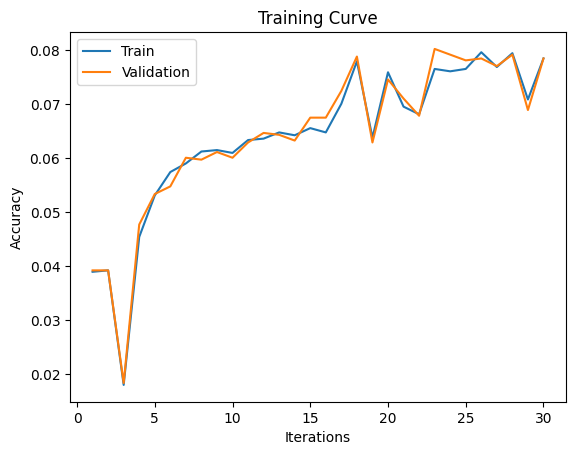

In [ ]:
# Batch Size = 256, Learning Rate = 0.005, num_epochs = 30
# Create an instance of the model.
model = HOGFeatureCNN()

if use_cuda and torch.cuda.is_available():
    "Using Cuda"
    model.cuda()

# Train the model
train_acc, val_acc= train_net(model, batch_size, train_loader, val_loader,
                                   learning_rate = 0.005, num_epochs = 30)
n = len(train_acc)
plt.title("Training Curve")
plt.plot(range(1,n+1), train_acc, label="Train")
plt.plot(range(1,n+1), val_acc, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

3. Data Preprocessing - Color Spectograms

In [2]:
# Mount the drive.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
# Now we move on to loading the .pt files defined for each class.
# Define the directory of spectograms.
spec_dir = '/content/drive/MyDrive/APS360_Team_15/Data/Xeno_Canto_Spectrograms'
# Define a list to store the spectograms and associated labels.
all_features = []
all_labels = []

# Iterare through each bird.
for file in os.listdir(spec_dir):
  # load the pt file.
  pt_file = glob.glob(os.path.join(spec_dir, file))
  # Error check
  if(pt_file == []):
    continue
  # Extract features and create labels in tensors.
  features_tensor = torch.load(pt_file[0])
  label_value = int(os.path.splitext(file)[0])
  labels_tensor = torch.full((features_tensor.shape[0],), label_value, dtype=torch.long)
  # Add these tensors to their respective lists.
  all_features.append(features_tensor)
  all_labels.append(labels_tensor)

In [29]:
# Print the number of classes for which data has been extracted.
num_classes = len(all_labels)
print(f"Number of classes for which data has been extracted: {num_classes}")

Number of classes for which data has been extracted: 3


In [30]:
all_features[0].dtype

torch.float32

In [31]:
# Concatenate all the tensors into one tensor.
features_tensor = torch.cat(all_features, dim=0)
labels_tensor = torch.cat(all_labels, dim=0)

# Encode the labels to make them suitable for training the model.
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels_tensor)
# Create mapping dictionaries for the encoding.
id_to_index = dict(zip(labels_tensor, encoded_labels))
index_to_id = dict(zip(encoded_labels, labels_tensor))
# Pickle dump these mappings for use later.
with open('label_mappings.pkl', 'wb') as f:
    pickle.dump({'id_to_index': id_to_index, 'index_to_id': index_to_id}, f)

# Replace the labels tensor.
labels_tensor = torch.from_numpy(encoded_labels)

# Print out stats.
print(f"Shape of features tensor: {features_tensor.shape}")
print(f"Shape of labels tensor: {labels_tensor.shape}")

# Convert the tensors into numpy for sci-kit learn functions.
features_np = features_tensor.numpy()
labels_np = labels_tensor.numpy()

# First split: (training + validation) vs test - 80:20
# We use a stratified split for uniform distributions of the classes.
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
temp_idx, test_idx = next(sss1.split(features_np, labels_np))

# Get the temporary set.
temp_features_np = features_np[temp_idx]
temp_labels_np = labels_np[temp_idx]

# Second split: training vs validation - 80:20
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
train_idx, val_idx = next(sss2.split(temp_features_np, temp_labels_np))

Shape of features tensor: torch.Size([521, 128, 128, 3])
Shape of labels tensor: torch.Size([521])


In [32]:
# Use the split indices to extract the data.
test_features_np = features_np[test_idx]
test_labels_np = labels_np[test_idx]
train_features_np = temp_features_np[train_idx]
train_labels_np = temp_labels_np[train_idx]
val_features_np = temp_features_np[val_idx]
val_labels_np = temp_labels_np[val_idx]

print(f"Shape of training features tensor: {train_features_np.shape}")
print(f"Shape of training labels tensor: {train_labels_np.shape}")
print(f"Shape of validation features tensor: {val_features_np.shape}")
print(f"Shape of validation labels tensor: {val_labels_np.shape}")
print(f"Shape of test features tensor: {test_features_np.shape}")
print(f"Shape of test labels tensor: {test_labels_np.shape}")

Shape of training features tensor: (332, 128, 128, 3)
Shape of training labels tensor: (332,)
Shape of validation features tensor: (84, 128, 128, 3)
Shape of validation labels tensor: (84,)
Shape of test features tensor: (105, 128, 128, 3)
Shape of test labels tensor: (105,)


In [33]:
# Convert the numpy arrays back to tensors.
train_features_tensor = torch.from_numpy(train_features_np)
train_labels_tensor = torch.from_numpy(train_labels_np)
val_features_tensor = torch.from_numpy(val_features_np)
val_labels_tensor = torch.from_numpy(val_labels_np)
test_features_tensor = torch.from_numpy(test_features_np)
test_labels_tensor = torch.from_numpy(test_labels_np)

print(f"Shape of training features tensor: {train_features_tensor.shape}")
print(f"Shape of training labels tensor: {train_labels_tensor.shape}")
print(f"Shape of validation features tensor: {val_features_tensor.shape}")
print(f"Shape of validation labels tensor: {val_labels_tensor.shape}")
print(f"Shape of test features tensor: {test_features_tensor.shape}")
print(f"Shape of test labels tensor: {test_labels_tensor.shape}")

Shape of training features tensor: torch.Size([332, 128, 128, 3])
Shape of training labels tensor: torch.Size([332])
Shape of validation features tensor: torch.Size([84, 128, 128, 3])
Shape of validation labels tensor: torch.Size([84])
Shape of test features tensor: torch.Size([105, 128, 128, 3])
Shape of test labels tensor: torch.Size([105])


In [34]:
# Create the datasets using the data tensors.
# This combines the labels and feature tensors.
# These can be used to create the dataloaders later.
train_dataset = TensorDataset(train_features_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_features_tensor, val_labels_tensor)
test_dataset = TensorDataset(test_features_tensor, test_labels_tensor)

4. CNN Model Implementation - Color Spectrograms

In [40]:
# Define the CNN Model
class SpectrogramsCNN(nn.Module):
    def __init__(self, num_classes=num_classes):
        super(SpectrogramsCNN, self).__init__()
        self.name = "SpectogramsCNN"

        # Input shape is [batch_size, 3, 128, 128] - note the channel dimension is 3, not 1
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # 3x128x128 -> 32x128x128
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 32x64x64 -> 64x64x64
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # 64x32x32 -> 128x32x32
        self.bn3 = nn.BatchNorm2d(128)

        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # Calculate size after convolutions and pooling
        # After 3 pooling operations of 2x2, dimensions are reduced by factor of 8
        # 128/8 = 16, so final feature map size is 128 x 16 x 16
        fc_input_size = 128 * 16 * 16

        # Fully connected layers
        self.fc1 = nn.Linear(fc_input_size, 512)
        self.dropout = nn.Dropout(0.5)  # for regularization
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # Input x is already shape [batch_size, 128, 128, 3]
        # PyTorch expects [batch_size, channels, height, width], so permute the dimensions
        x = x.permute(0, 3, 1, 2)  # Change from [B, H, W, C] to [B, C, H, W]

        # Convolutional blocks
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # -> [B, 32, 64, 64]
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # -> [B, 64, 32, 32]
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # -> [B, 128, 16, 16]

        # Flatten for fully connected layers
        x = x.reshape(x.size(0), -1)  # -> [B, 128*16*16]

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [45]:
# Helper function to create a name for each model on the basis of its hyperparameters.
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [41]:
# Function to train the model. Largely based on Archit's Lab 3 Submission.
def train_net(model, batch_size, train_loader, val_loader, learning_rate=0.001, num_epochs=20):
    # Fixed PyTorch random seed for reproducible results
    torch.manual_seed(1000)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    # Optional: Add scheduler later - it controls the learning rate.
    print("Loss Function and Optimizer set up.")

    # Arrays to store accuracy metrics
    train_acc = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)

    # Training loop
    start_time = time.time()
    print("Training Started.")

    # Iterate for number of epochs.
    for epoch in range(num_epochs):
        # Training phase
        model.train()

        # Process training batches
        for _, data in enumerate(train_loader, 0):
            recordings, labels = data

            # Move data to GPU if available
            if use_cuda and torch.cuda.is_available():
                recordings = recordings.cuda()
                labels = labels.cuda()

            # Forward and backward passes
            optimizer.zero_grad()
            outputs = model(recordings)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        print("Finished with adjusting parameters")

        # Evaluation phase
        model.eval()
        correct_t, total_t = 0, 0
        correct_v, total_v = 0, 0

        # Calculate training accuracy
        with torch.no_grad():
            for recordings, labels in train_loader:
                if use_cuda and torch.cuda.is_available():
                    recordings = recordings.cuda()
                    labels = labels.cuda()

                output = model(recordings)
                pred = output.max(1, keepdim=True)[1]
                correct_t += pred.eq(labels.view_as(pred)).sum().item()
                total_t += recordings.shape[0]

        train_acc[epoch] = correct_t / total_t

        # Calculate validation accuracy
        with torch.no_grad():
            for recordings, labels in val_loader:
                if use_cuda and torch.cuda.is_available():
                    recordings = recordings.cuda()
                    labels = labels.cuda()

                output = model(recordings)
                pred = output.max(1, keepdim=True)[1]
                correct_v += pred.eq(labels.view_as(pred)).sum().item()
                total_v += recordings.shape[0]

        val_acc[epoch] = correct_v / total_v

        # Print epoch results
        print(f"Epoch {epoch + 1}: Train acc: {train_acc[epoch]:.4f}, Validation acc: {val_acc[epoch]:.4f}")

        # Save model checkpoint
        model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)

    print('Finished Training')
    elapsed_time = time.time() - start_time

    # Save metrics to CSV
    np.savetxt(f"{model_path}_train_acc.csv", train_acc)
    np.savetxt(f"{model_path}_val_acc.csv", val_acc)

    return train_acc, val_acc

In [42]:
# Create the data loaders.
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [43]:
use_cuda = True

Loss Function and Optimizer set up.
Training Started.
Finished with adjusting parameters
Epoch 1: Train acc: 0.3976, Validation acc: 0.4048
Finished with adjusting parameters
Epoch 2: Train acc: 0.4729, Validation acc: 0.4524
Finished with adjusting parameters
Epoch 3: Train acc: 0.5693, Validation acc: 0.5714
Finished with adjusting parameters
Epoch 4: Train acc: 0.5693, Validation acc: 0.5714
Finished with adjusting parameters
Epoch 5: Train acc: 0.6024, Validation acc: 0.5952
Finished with adjusting parameters
Epoch 6: Train acc: 0.6325, Validation acc: 0.6310
Finished with adjusting parameters
Epoch 7: Train acc: 0.6687, Validation acc: 0.6190
Finished with adjusting parameters
Epoch 8: Train acc: 0.6657, Validation acc: 0.5952
Finished with adjusting parameters
Epoch 9: Train acc: 0.6596, Validation acc: 0.5833
Finished with adjusting parameters
Epoch 10: Train acc: 0.7018, Validation acc: 0.6071
Finished with adjusting parameters
Epoch 11: Train acc: 0.6596, Validation acc: 0.571

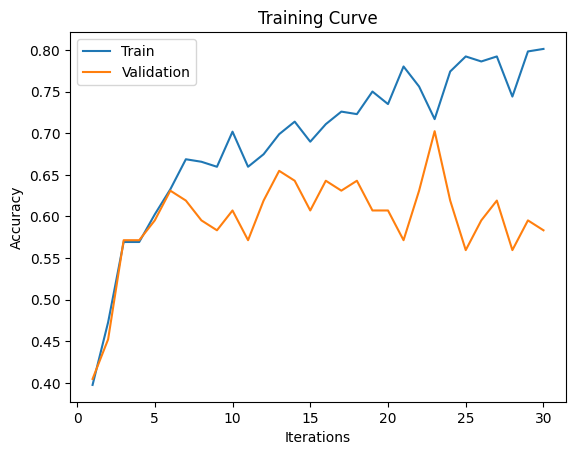

In [46]:
# Batch Size = 32, Learning Rate = 0.005, num_epochs = 30
# Create an instance of the model.
model = SpectrogramsCNN()

if use_cuda and torch.cuda.is_available():
    "Using Cuda"
    model.cuda()

# Train the model
train_acc, val_acc= train_net(model, batch_size, train_loader, val_loader,
                                   learning_rate = 0.005, num_epochs = 30)
n = len(train_acc)
plt.title("Training Curve")
plt.plot(range(1,n+1), train_acc, label="Train")
plt.plot(range(1,n+1), val_acc, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()